In [1]:
# import package
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import dump
from pickle import load

In [2]:
# import data
# docker: /opt/nb/Desktop/...
# local: (copy file path and paste)
train = pd.read_csv('Datasets/bearings/NB.csv')
train['Fault'] = 0

test = pd.read_csv('Datasets/bearings/IR - 7.csv')
test['Fault'] = 1

dataset = train.append(test)
dataset

,DE,FE,Fault
0,0.064254,0.038625,0
1,0.063002,0.096769,0
2,-0.004381,0.127382,0
3,-0.035882,0.144640,0
4,-0.023991,0.086702,0
...,...,...,...
121150,0.135958,-0.047255,1
121151,-0.083167,-0.070882,1
121152,0.391469,-0.181005,1
121153,0.185501,0.136011,1


## Data understanding

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242310 entries, 0 to 121154
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DE      242310 non-null  float64
 1   FE      242310 non-null  float64
 2   Fault   242310 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 7.4 MB


### Basic statistics

In [4]:
dataset.describe()

,DE,FE,Fault
count,242310.000000,242310.000000,242310.000000
mean,0.008163,0.033348,0.500000
std,0.216483,0.170863,0.500001
min,-1.425531,-0.895782,0.000000
25%,-0.065505,-0.041913,0.000000
50%,0.011474,0.031435,0.500000
75%,0.080317,0.107658,1.000000
max,1.639620,0.957213,1.000000


### EDA

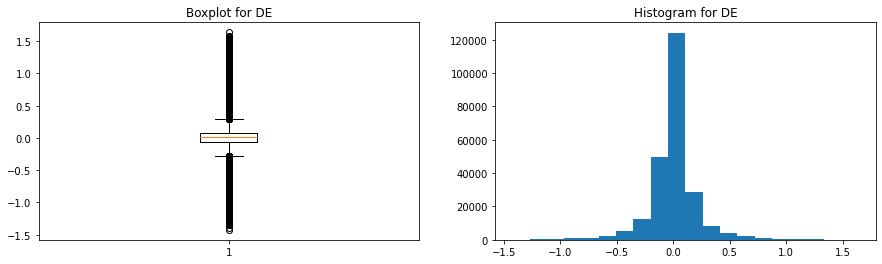

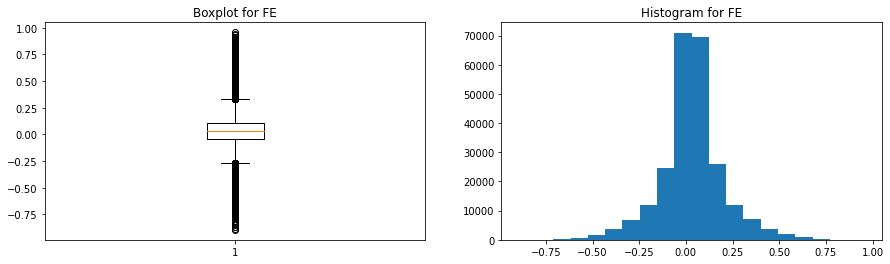

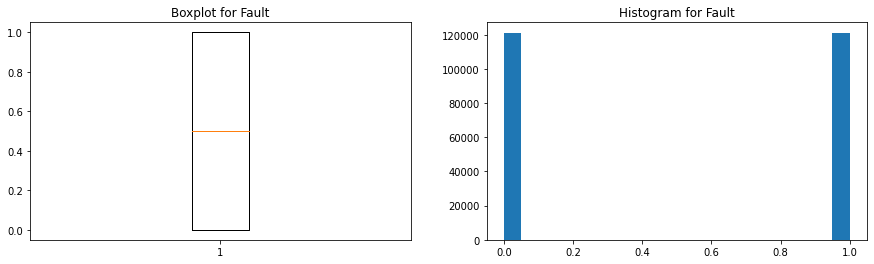

In [5]:
# Boxpot and histogram of each feature
for (columnName, columnData) in dataset.iteritems():
    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

    # Extracting the feature values
    x = columnData

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(columnName) )

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(columnName) )

    # Display
    plt.show()

### Null and duplicated value check

In [6]:
# Checking for null values
features = ['DE', 'FE', 'Fault']
N_null = sum(dataset[features].isnull().sum())
print("The dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The dataset contains 0 null values
The dataset contains 6941 duplicates


6941 duplicated values are dropped

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235369 entries, 0 to 235368
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DE      235369 non-null  float64
 1   FE      235369 non-null  float64
 2   Fault   235369 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 5.4 MB


### Correlation matrix and heatmap

In [8]:
dataset.corr()

,DE,FE,Fault
DE,1.000000,0.088877,-0.015778
FE,0.088877,1.000000,0.002574
Fault,-0.015778,0.002574,1.000000


<AxesSubplot:>

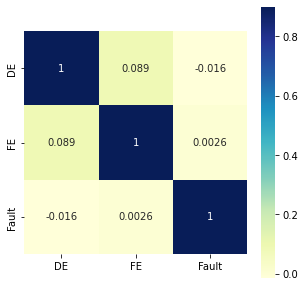

In [9]:
# make correlation matrix to heatmap
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(dataset.corr(), cmap='YlGnBu', vmax = .9, square = True, annot=True)

In [10]:
def plot_feature(data, dataName):
    x = list(range(len(data.index)))
    y = data

    # plot the humidity data
    fig = plt.subplots(figsize=(18, 6))
    #fig = plt.figure()
    plt.plot(x,y)
    plt.ylabel(dataName)
    plt.xlabel('Index')

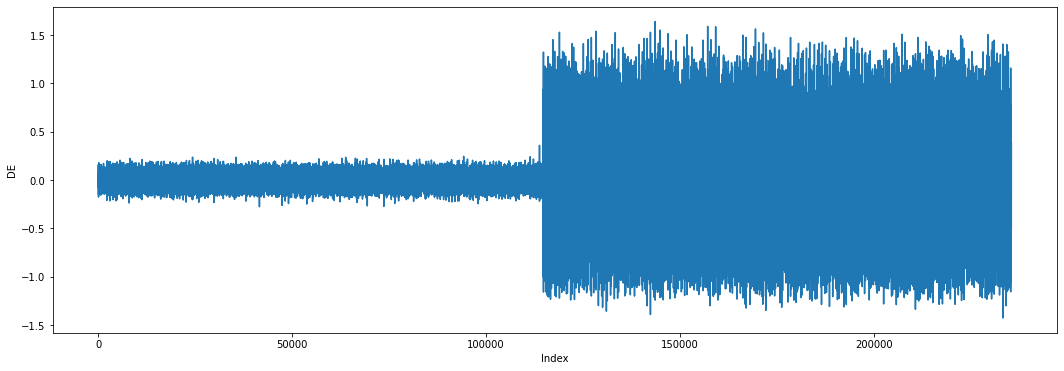

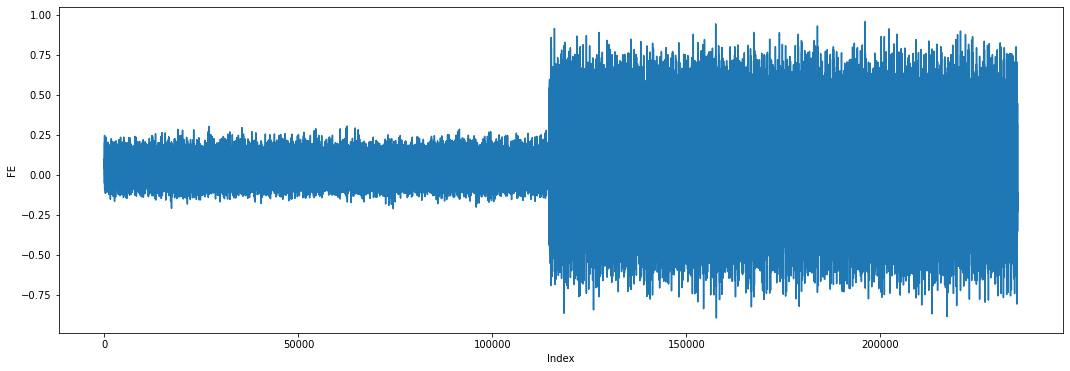

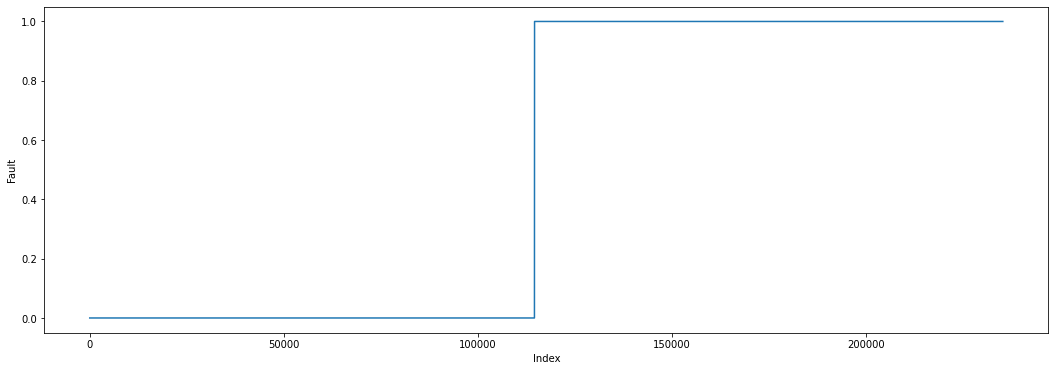

In [11]:
for (columnName, columnData) in dataset.iteritems():
    plot_feature(columnData, columnName)

## Data preparation

### Feature engineering

### Split data

In [12]:
#split the data into independent 'X' and dependent 'Y' variables
X = dataset.iloc[:, 0:2].values
y = dataset.iloc[:, 2]

In [13]:
#split the data set into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

##### Save traing data and testing data to file for later use

In [14]:
dump(X_train, open("pickle/dataset/bearing-failure-prediction/X_train.pkl", "wb"))
dump(y_train, open("pickle/dataset/bearing-failure-prediction/y_train.pkl", "wb"))
dump(X_test, open("pickle/dataset/bearing-failure-prediction/X_test.pkl", "wb"))
dump(y_test, open("pickle/dataset/bearing-failure-prediction/y_test.pkl", "wb"))

#### Scaler

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [16]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train)
X_test_mm = mm.transform(X_test)

#### Save scaled training and testing data

In [17]:
dump(X_train_sc, open("pickle/dataset/bearing-failure-prediction/X_train_sc.pkl", "wb"))
dump(X_test_sc, open("pickle/dataset/bearing-failure-prediction/X_test_sc.pkl", "wb"))
dump(X_train_mm, open("pickle/dataset/bearing-failure-prediction/X_train_mm.pkl", "wb"))
dump(X_test_mm, open("pickle/dataset/bearing-failure-prediction/X_test_mm.pkl", "wb"))

## Modeling

In [18]:
def train_models(X_train, y_train):
  #use logistic regression
  from sklearn.linear_model import LogisticRegression
  log = LogisticRegression(random_state = 0)
  log.fit(X_train, y_train)

  #use KNeighbors
  from sklearn.neighbors import KNeighborsClassifier
  knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p=2)
  knn.fit(X_train, y_train)

  #use SVC (liner kernel)
  from sklearn.svm import SVC
  svc_lin = SVC(kernel = 'linear', random_state = 0)
  svc_lin.fit(X_train, y_train)

  #use SVC (RBF kernel)
  from sklearn.svm import SVC
  svc_rbf = SVC(kernel = 'rbf', random_state = 0)
  svc_rbf.fit(X_train, y_train)

  #use GaussianNB
  from sklearn.naive_bayes import GaussianNB
  gauss = GaussianNB()
  gauss.fit(X_train, y_train)

  #use Decision Tree
  from sklearn.tree import DecisionTreeClassifier
  tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
  tree.fit(X_train, y_train)

  #use the RandomForestClassifier
  from sklearn.ensemble import RandomForestClassifier
  forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
  forest.fit(X_train, y_train)

  #print the tranning accurancy of each model
  print('[0]Logistic Regression Tranning Accurancy: ', log.score(X_train, y_train))
  print('[1]KNeighbors Tranning Accurancy: ', knn.score(X_train, y_train))
  print('[2]SVC (liner kernel) Tranning Accurancy: ', svc_lin.score(X_train, y_train))
  print('[3]SVC (RBF kernel) Tranning Accurancy: ', svc_rbf.score(X_train, y_train))
  print('[4]GaussianNB Tranning Accurancy: ', gauss.score(X_train, y_train))
  print('[5]Decision Tree Tranning Accurancy: ', tree.score(X_train, y_train))
  print('[6]RandomForestClassifier Tranning Accurancy: ', forest.score(X_train, y_train))

  return log, knn, svc_lin, svc_rbf, gauss, tree, forest

### Try with standard scaled training data first

In [19]:
# load data
X_train_sc = load(open('pickle/dataset/bearing-failure-prediction/X_train_sc.pkl', 'rb'))
X_test_sc = load(open('pickle/dataset/bearing-failure-prediction/X_test_sc.pkl', 'rb'))
y_train = load(open('pickle/dataset/bearing-failure-prediction/y_train.pkl', 'rb'))
y_test = load(open('pickle/dataset/bearing-failure-prediction/y_test.pkl', 'rb'))

In [20]:
models_sc = train_models(X_train_sc, y_train)

[0]Logistic Regression Tranning Accurancy:  0.4665763828035795
[1]KNeighbors Tranning Accurancy:  0.8840171008258318
[2]SVC (liner kernel) Tranning Accurancy:  0.5133859104065429
[3]SVC (RBF kernel) Tranning Accurancy:  0.8637297857085956
[4]GaussianNB Tranning Accurancy:  0.8606335802862529
[5]Decision Tree Tranning Accurancy:  0.9999787567380971
[6]RandomForestClassifier Tranning Accurancy:  0.9836479991502696


In [22]:
for i in range(len(models_sc)):
    # save model
    fileName = 'pickle/models/bearing_classifiers/standard_scaled/' + str(models_sc[i].__class__.__name__) + '.pkl'
    dump(models_sc[i], open(fileName, 'wb'))

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
def print_scores(y, y_pred, model):
    print(
        'Accuracy score: {:.02%}, Precision: {:.02%}, Recall: {:.02%}, F1 score: {:.02%} '.format(
            accuracy_score(y, y_pred),
            precision_score(y, y_pred, pos_label=1),
            recall_score(y, y_pred, pos_label=1),
            f1_score(y, y_pred, pos_label=1)
        ), model
    )

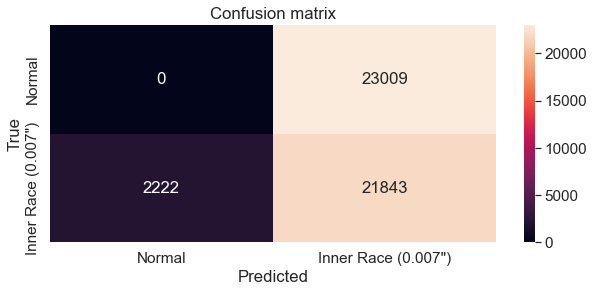

Accuracy score: 46.40%, Precision: 48.70%, Recall: 90.77%, F1 score: 63.39%  LogisticRegression(random_state=0)


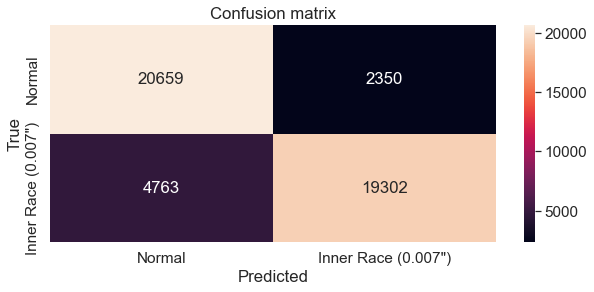

Accuracy score: 84.89%, Precision: 89.15%, Recall: 80.21%, F1 score: 84.44%  KNeighborsClassifier()


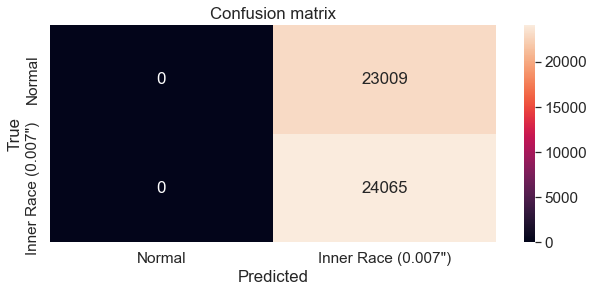

Accuracy score: 51.12%, Precision: 51.12%, Recall: 100.00%, F1 score: 67.66%  SVC(kernel='linear', random_state=0)


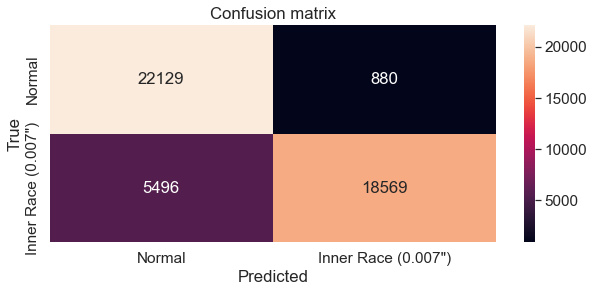

Accuracy score: 86.46%, Precision: 95.48%, Recall: 77.16%, F1 score: 85.35%  SVC(random_state=0)


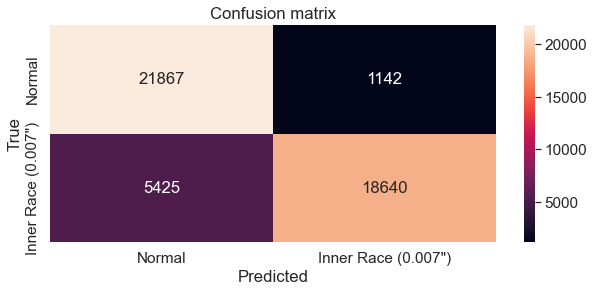

Accuracy score: 86.05%, Precision: 94.23%, Recall: 77.46%, F1 score: 85.02%  GaussianNB()


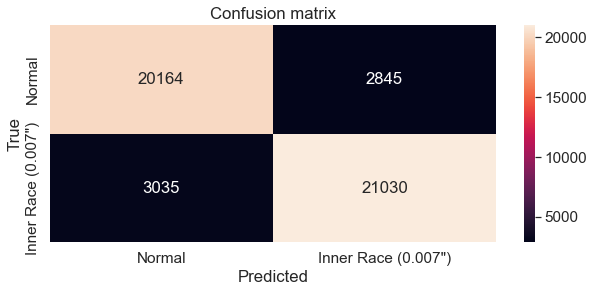

Accuracy score: 87.51%, Precision: 88.08%, Recall: 87.39%, F1 score: 87.73%  DecisionTreeClassifier(criterion='entropy', random_state=0)


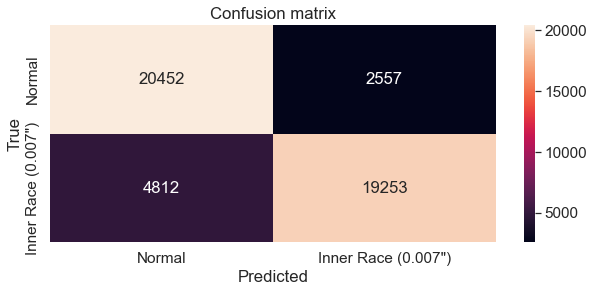

Accuracy score: 84.35%, Precision: 88.28%, Recall: 80.00%, F1 score: 83.94%  RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)


In [24]:
for i in range(len(models_sc)):
  y_pred = models_sc[i].predict(X_test_sc)
  cm = confusion_matrix(y_test, y_pred)
  index = ['Normal','Inner Race (0.007")']  
  columns = ['Normal','Inner Race (0.007")']  
  cm_df = pd.DataFrame(cm,columns,index)  


  plt.figure(figsize=(10,4))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(cm_df, annot=True, fmt='g') # font size
  plt.title('Confusion matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  print_scores(y_test, y_pred, models_sc[i])

## Try with Min_Max_scaled data

In [25]:
# load data
X_train_mm = load(open('pickle/dataset/bearing-failure-prediction/X_train_mm.pkl', 'rb'))
X_test_mm = load(open('pickle/dataset/bearing-failure-prediction/X_test_mm.pkl', 'rb'))
y_train = load(open('pickle/dataset/bearing-failure-prediction/y_train.pkl', 'rb'))
y_test = load(open('pickle/dataset/bearing-failure-prediction/y_test.pkl', 'rb'))

In [26]:
min_max_scaled_models = train_models(X_train_mm, y_train)

[0]Logistic Regression Tranning Accurancy:  0.4669693831487825
[1]KNeighbors Tranning Accurancy:  0.8842985740460447
[2]SVC (liner kernel) Tranning Accurancy:  0.5133859104065429
[3]SVC (RBF kernel) Tranning Accurancy:  0.8625401630420351
[4]GaussianNB Tranning Accurancy:  0.8606335802862529
[5]Decision Tree Tranning Accurancy:  0.9999681351071457
[6]RandomForestClassifier Tranning Accurancy:  0.983807323614541


In [27]:
for i in range(len(min_max_scaled_models)):
    # save model
    fileName = 'pickle/models/bearing_classifiers/min_max_scaled/' + str(models_sc[i].__class__.__name__) + '.pkl'
    dump(min_max_scaled_models[i], open(fileName, 'wb'))

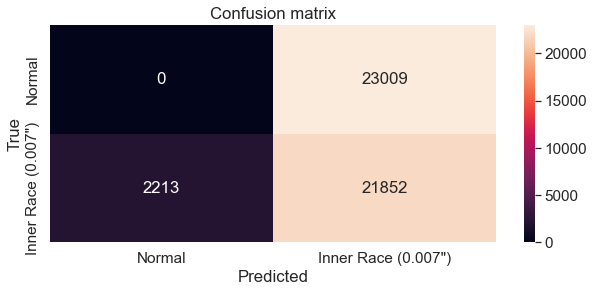

Accuracy score: 46.42%, Precision: 48.71%, Recall: 90.80%, F1 score: 63.41%  LogisticRegression(random_state=0)


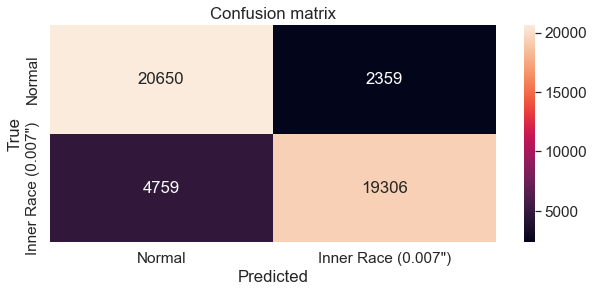

Accuracy score: 84.88%, Precision: 89.11%, Recall: 80.22%, F1 score: 84.43%  KNeighborsClassifier()


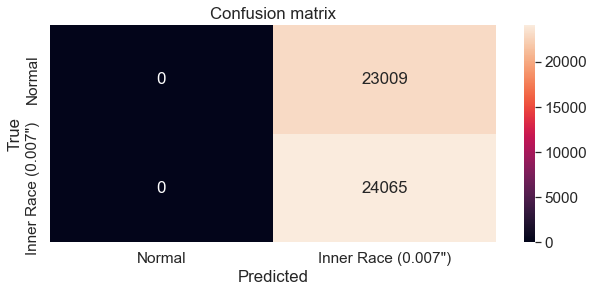

Accuracy score: 51.12%, Precision: 51.12%, Recall: 100.00%, F1 score: 67.66%  SVC(kernel='linear', random_state=0)


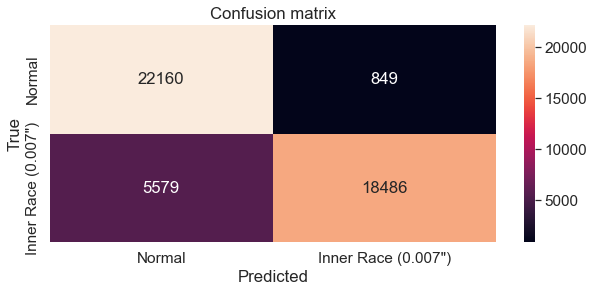

Accuracy score: 86.34%, Precision: 95.61%, Recall: 76.82%, F1 score: 85.19%  SVC(random_state=0)


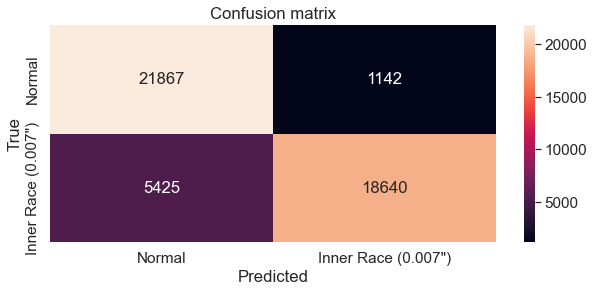

Accuracy score: 86.05%, Precision: 94.23%, Recall: 77.46%, F1 score: 85.02%  GaussianNB()


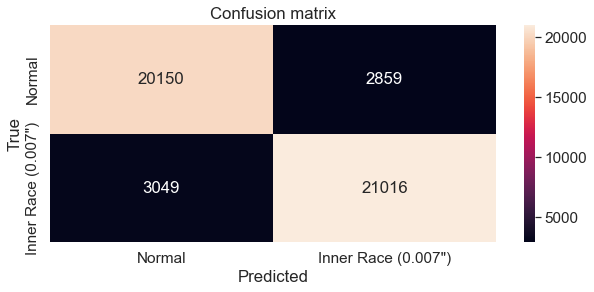

Accuracy score: 87.45%, Precision: 88.03%, Recall: 87.33%, F1 score: 87.68%  DecisionTreeClassifier(criterion='entropy', random_state=0)


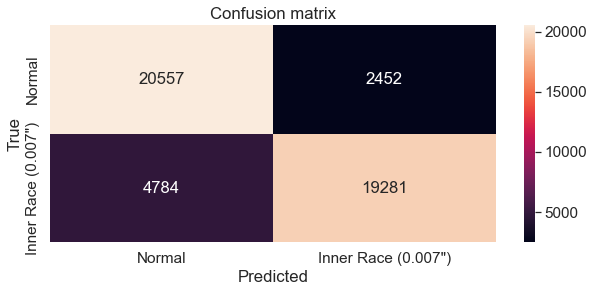

Accuracy score: 84.63%, Precision: 88.72%, Recall: 80.12%, F1 score: 84.20%  RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)


In [28]:
for i in range(len(min_max_scaled_models)):
  y_pred = min_max_scaled_models[i].predict(X_test_mm)
  cm = confusion_matrix(y_test, y_pred)
  index = ['Normal','Inner Race (0.007")']  
  columns = ['Normal','Inner Race (0.007")']  
  cm_df = pd.DataFrame(cm,columns,index)  


  plt.figure(figsize=(10,4))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(cm_df, annot=True, fmt='g') # font size
  plt.title('Confusion matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  print_scores(y_test, y_pred, min_max_scaled_models[i])


### TPOT

In [ ]:
# load data
X_train = load(open('pickle/dataset/bearing-failure-prediction/X_train.pkl', 'rb'))
X_test = load(open('pickle/dataset/bearing-failure-prediction/X_test.pkl', 'rb'))
y_train = load(open('pickle/dataset/bearing-failure-prediction/y_train.pkl', 'rb'))
y_test = load(open('pickle/dataset/bearing-failure-prediction/y_test.pkl', 'rb'))

In [31]:
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from tpot import TPOTClassifier

# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search
model = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2, random_state=1, n_jobs=-1)
# perform the search
model.fit(X_train, y_train)
# export the best model
model.export('bearing_classification_tpot_best_model.py')

                                                                                   
Generation 1 - Current best internal CV score: 0.8995229078175992
                                                                                   
Generation 2 - Current best internal CV score: 0.8995229078175992
                                                                                  
Generation 3 - Current best internal CV score: 0.8995229078175992
                                                                                  
Generation 4 - Current best internal CV score: 0.9757667422450844
                                                             
Generation 5 - Current best internal CV score: 0.9868663499817293
                                                             
Best pipeline: ExtraTreesClassifier(SelectPercentile(MinMaxScaler(input_matrix), percentile=31), bootstrap=False, criterion=entropy, max_features=0.7000000000000001, min_samples_leaf=8, min_samples_split=16, n_es

In [75]:
model.export('/Users/yi-chenlin/Desktop/Final project/TPOT/bearing_classifiers/bearing_classification_tpot_best_model.py')

In [34]:
model.score(X_train, y_train)

0.9905786133460793

the following matrix should be re-made since the scores are not corrrect

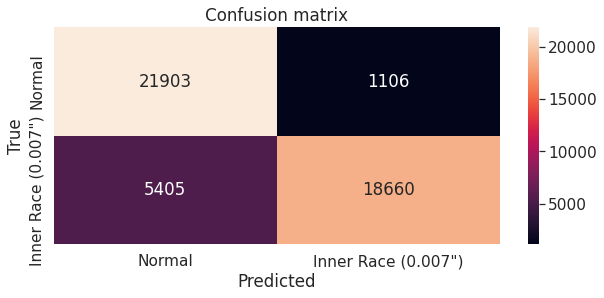

Accuracy score: 86.17%, Precision: 77.54%, Recall: 94.40%, F1 score: 85.15%  AutoSklearnClassifier(n_jobs=8, per_run_time_limit=30,
                      time_left_for_this_task=120)


In [35]:
y_pred_tpot = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_tpot)
index = ['Normal','Inner Race (0.007")']  
columns = ['Normal','Inner Race (0.007")']  
cm_df = pd.DataFrame(cm,columns,index)  


plt.figure(figsize=(10,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_df, annot=True, fmt='g') # font size
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print_scores(y_pred_tpot, y_test, model)

In [36]:
model.score(X_test, y_test)

0.9886136720907507

In [37]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_tpot, target_names=['Normal','Inner Race (0.007")'])
print(cr)

                     precision    recall  f1-score   support

             Normal       1.00      0.98      0.99     23009
Inner Race (0.007")       0.98      1.00      0.99     24065

           accuracy                           0.99     47074
          macro avg       0.99      0.99      0.99     47074
       weighted avg       0.99      0.99      0.99     47074



## Auto-sklearn

In [2]:
# print autosklearn version
import autosklearn
print('autosklearn: %s' % autosklearn.__version__)

autosklearn: 0.14.3


In [4]:
X_train = load(open('/opt/nb/Desktop/Predcitive Maintenance with Machine Learning_Yi-Chen Lin/pickle/dataset/bearing-failure-prediction/X_train.pkl', 'rb'))
y_train = load(open('/opt/nb/Desktop/Predcitive Maintenance with Machine Learning_Yi-Chen Lin/pickle/dataset/bearing-failure-prediction/y_train.pkl', 'rb'))
X_test = load(open('/opt/nb/Desktop/Predcitive Maintenance with Machine Learning_Yi-Chen Lin/pickle/dataset/bearing-failure-prediction/X_test.pkl', 'rb'))
y_test = load(open('/opt/nb/Desktop/Predcitive Maintenance with Machine Learning_Yi-Chen Lin/pickle/dataset/bearing-failure-prediction/y_test.pkl', 'rb'))

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from autosklearn.classification import AutoSklearnClassifier

# define search
model = AutoSklearnClassifier(time_left_for_this_task=2*60, per_run_time_limit=30, n_jobs=8)
# perform the search
model.fit(X_train, y_train)
# summarize
print(model.sprint_statistics())
# evaluate best model
y_hat = model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
print("Accuracy: %.3f" % acc)

auto-sklearn results:
  Dataset name: 491f6aa3-7846-11ec-802f-7d51c86389fc
  Metric: accuracy
  Best validation score: 0.863594
  Number of target algorithm runs: 26
  Number of successful target algorithm runs: 4
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 21
  Number of target algorithms that exceeded the memory limit: 0

Accuracy: 0.862


In [6]:
dump(model, open('/opt/nb/Desktop/Predcitive Maintenance with Machine Learning_Yi-Chen Lin/pickle/models/bearing_classifiers/auto_sklearn.pkl', 'wb'))

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
def print_scores(y, y_pred, model):
    print(
        'Accuracy score: {:.02%}, Precision: {:.02%}, Recall: {:.02%}, F1 score: {:.02%} '.format(
            accuracy_score(y, y_pred),
            precision_score(y, y_pred, pos_label=1),
            recall_score(y, y_pred, pos_label=1),
            f1_score(y, y_pred, pos_label=1)
        ), model
    )

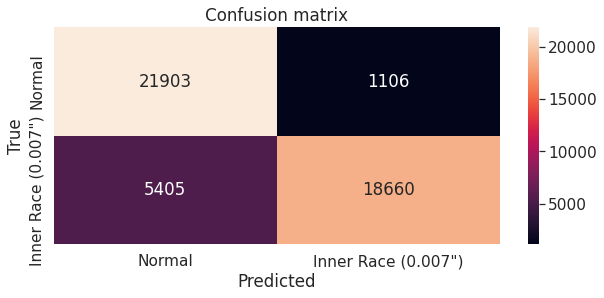

Accuracy score: 86.17%, Precision: 94.40%, Recall: 77.54%, F1 score: 85.15%  AutoSklearnClassifier(n_jobs=8, per_run_time_limit=30,
                      time_left_for_this_task=120)


In [11]:
cm = confusion_matrix(y_test, y_hat)
index = ['Normal','Inner Race (0.007")']  
columns = ['Normal','Inner Race (0.007")']  
cm_df = pd.DataFrame(cm,columns,index)  


plt.figure(figsize=(10,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_df, annot=True, fmt='g') # font size
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print_scores(y_test, y_hat, model)